In [2]:
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(nnet)
library(glmnet)
library(car)
library(themis)
library(pROC)
library(reshape2)
library(MASS)

In [3]:
test <- read_csv('../data/testset.csv')

Rows: 76104 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
train_base <- read_csv('../data/training_sets/train_base.csv')
train_under <- read_csv('../data/training_sets/train_under.csv')
train_over <- read_csv('../data/training_sets/train_over.csv')
train_combine <- read_csv('../data/training_sets/train_combine.csv')
train_smote <- read_csv('../data/training_sets/train_smote.csv')

Rows: 177576 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9696 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 448734 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (22): Diabetes_012, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, He...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the co

In [5]:
eval_multi_class <- function(x) {
    cc <- sum(diag(x), na.rm = TRUE)
    sc <- sum(x)
    pp <- colSums(x)
    tt <- rowSums(x)
    
    prec <- diag(x) / colSums(x)
    recall <- diag(x) / rowSums(x)
    macro_prec <- mean(prec, na.rm = TRUE)
    macro_recall <- mean(recall, na.rm = TRUE)
    macro_f1 <- 2 * macro_prec * macro_recall / (macro_prec + macro_recall)
    acc <- cc / sc
    
    denominator <- (sc^2 - sum(pp * tt))
    if (denominator != 0) {
        kap <- (as.numeric(cc) * as.numeric(sc) - sum(pp * tt)) / denominator
    } else {
        kap <- NA
    }
    
    return(list(Precision = prec, Recall = recall, Accuracy = acc, Kappa = kap, Macro_F1 = macro_f1))
}

#### Model với tất cả các biến

In [7]:
first_models <- list()

for (i in 1:4) {
    if (i == 1) {
        df <- train_under
    } else if (i == 2) {
        df <- train_over
    } else if (i == 3) {
        df <- train_combine
    } else {
        df <- train_smote
    }
    
    model <- multinom(Diabetes_012 ~ ., data = df, maxit = 1000)
    pred_class <- predict(model, test, type = 'class')
    
    cm <- table(test$Diabetes_012, pred_class)
    eval <- eval_multi_class(cm)
    
    first_models[[i]] <- list(Model = model, Prediction_Class = pred_class, Confusion_Matrix = cm, Evaluation = eval)
}


# weights:  69 (44 variable)
initial  value 10652.144751 
iter  10 value 9744.257556
iter  20 value 9528.172274
iter  30 value 9399.776835
iter  40 value 9258.014609
iter  50 value 9214.081944
final  value 9214.079505 
converged
# weights:  69 (44 variable)
initial  value 492984.686742 
iter  10 value 454100.958198
iter  20 value 446031.713713
iter  30 value 444525.986389
iter  40 value 433387.485717
iter  50 value 426663.745668
final  value 426663.706103 
converged
# weights:  69 (44 variable)
initial  value 195087.175773 
iter  10 value 175501.078653
iter  20 value 172628.925483
iter  30 value 171955.055235
iter  40 value 169961.157023
iter  50 value 168805.474858
final  value 168805.436928 
converged
# weights:  69 (44 variable)
initial  value 492984.686742 
iter  10 value 454085.871213
iter  20 value 443830.287775
iter  30 value 441206.341870
iter  40 value 435924.125540
iter  50 value 421973.436247
final  value 421972.781145 
converged


In [8]:
# lấy ra các evalution của từng model
evaluations <- lapply(first_models, function(x) x$Evaluation)

for (i in 1:4) {
    if (i == 1) {
        cat('Undersampling\n')
    } else if (i == 2) {
        cat('Oversampling\n')
    } else if (i == 3) {
        cat('Combine\n')
    } else {
        cat('SMOTE\n')
    }
    
    print(evaluations[[i]])
    cat('\n')
}

Undersampling
$Precision
         0          1          2 
0.95036052 0.03136971 0.34686120 

$Recall
        0         1         2 
0.6577310 0.3102216 0.5864839 

$Accuracy
[1] 0.641438

$Kappa
[1] 0.2413317

$Macro_F1
[1] 0.477556


Oversampling
$Precision
         0          1          2 
0.95000225 0.03259091 0.35044630 

$Recall
        0         1         2 
0.6586979 0.3273767 0.5826087 

$Accuracy
[1] 0.6420293

$Kappa
[1] 0.2419211

$Macro_F1
[1] 0.4804311


Combine
$Precision
         0          1          2 
0.95012346 0.03209894 0.35050666 

$Recall
        0         1         2 
0.6600858 0.3209435 0.5819471 

$Accuracy
[1] 0.6429885

$Kappa
[1] 0.242482

$Macro_F1
[1] 0.4795663


SMOTE
$Precision
        0         1         2 
0.9497741 0.0302553 0.3548675 

$Recall
        0         1         2 
0.6523041 0.3295211 0.5643667 

$Accuracy
[1] 0.6341454

$Kappa
[1] 0.2345763

$Macro_F1
[1] 0.4775988




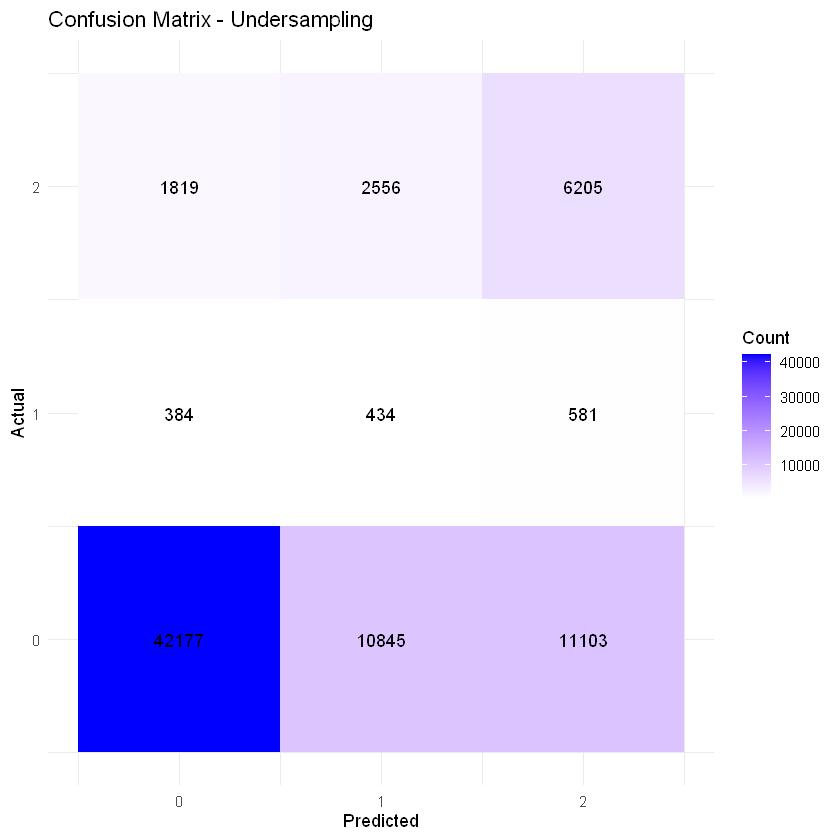

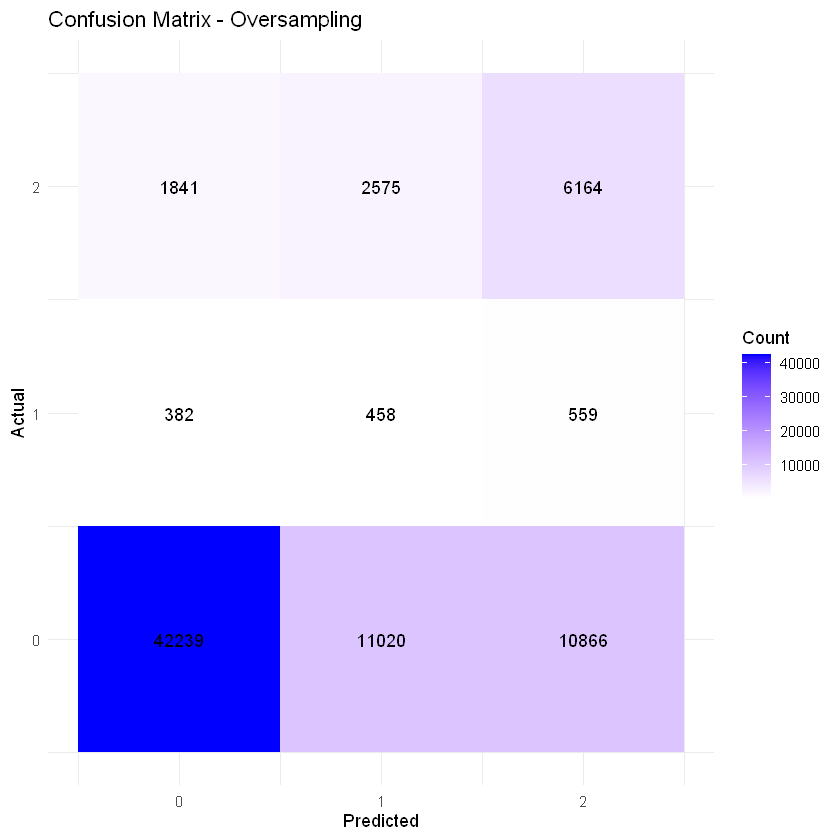

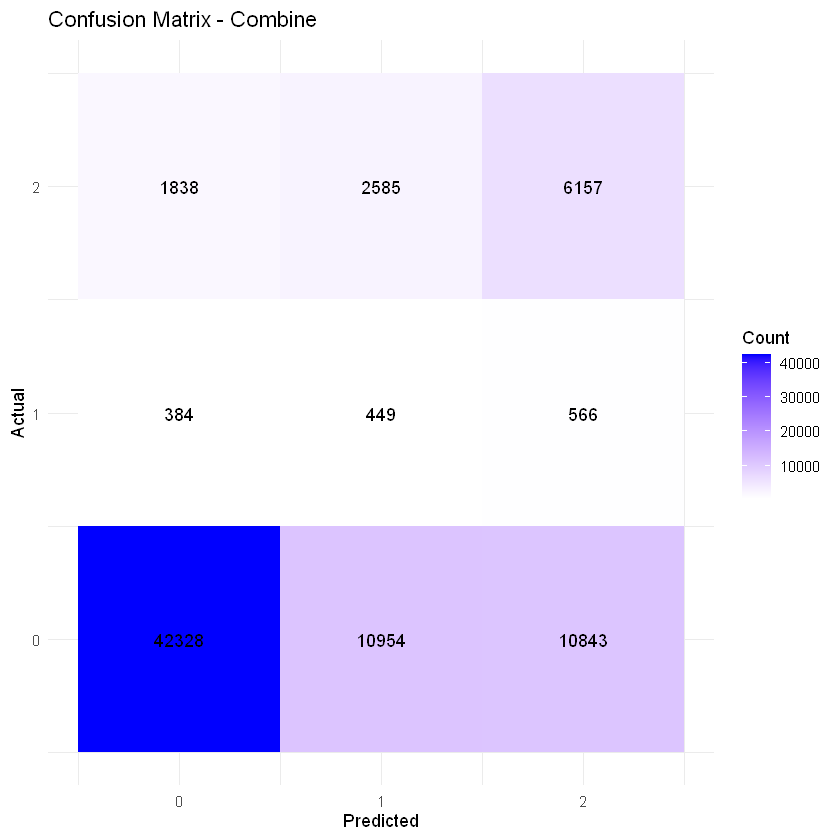

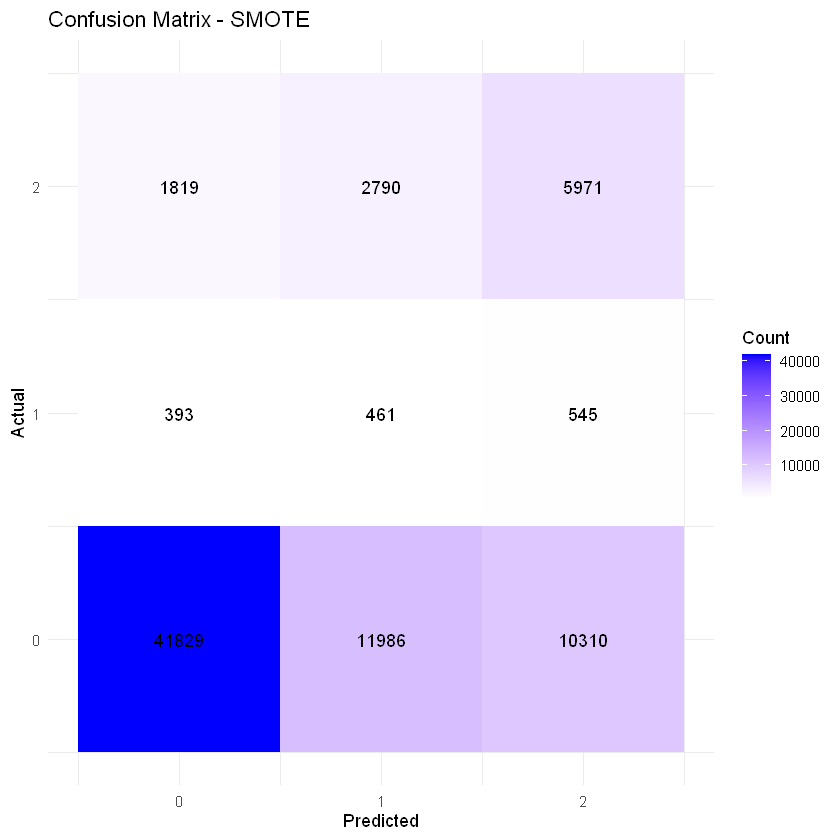

In [18]:
# vẽ trực quan confusion matrix của từng model
sampling_methods <- c("Undersampling", "Oversampling", "Combine", "SMOTE")

for (i in 1:4) {    
    cm <- first_models[[i]]$Confusion_Matrix
    cm_melt <- melt(cm)
    colnames(cm_melt) <- c("Var1", "Var2", "value")
    p <- ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
        geom_tile() +
        geom_text(aes(label = value), color = "black") +
        scale_fill_gradient(low = "white", high = "blue") +
        labs(x = "Predicted", y = "Actual", fill = "Count") +
        ggtitle(paste("Confusion Matrix -", sampling_methods[i])) +
        theme_minimal()

    print(p)
}

Nhận thấy model chạy với train_combine có vẻ cho kết quả tốt nhất trong phân loại nhóm 1 và 2.

### Stepwise

In [111]:
full_model <- multinom(Diabetes_012 ~ ., data = train_combine, maxit = 1500)

stepwise_model <- stepAIC(full_model, direction = "both", trace = TRUE)

# weights:  69 (44 variable)
initial  value 195087.175773 
iter  10 value 175501.078653
iter  20 value 172628.925483
iter  30 value 171955.055235
iter  40 value 169961.157023
iter  50 value 168805.474858
final  value 168805.436928 
converged
Start:  AIC=337698.9
Diabetes_012 ~ HighBP + HighChol + CholCheck + BMI + Smoker + 
    Stroke + HeartDiseaseorAttack + PhysActivity + Fruits + Veggies + 
    HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + GenHlth + 
    MentHlth + PhysHlth + DiffWalk + Sex + Age + Education + 
    Income

# weights:  66 (42 variable)
initial  value 195087.175773 
iter  10 value 176998.585675
iter  20 value 174168.712045
iter  30 value 173473.890567
iter  40 value 170669.682067
final  value 170001.318097 
converged
# weights:  66 (42 variable)
initial  value 195087.175773 
iter  10 value 176650.311943
iter  20 value 173909.536104
iter  30 value 173129.199126
iter  40 value 170672.042924
final  value 170004.708914 
converged
# weights:  66 (42 variable)
initial  

In [112]:
summary(stepwise_model)

Call:
multinom(formula = Diabetes_012 ~ HighBP + HighChol + CholCheck + 
    BMI + Smoker + Stroke + HeartDiseaseorAttack + PhysActivity + 
    Fruits + Veggies + HvyAlcoholConsump + AnyHealthcare + NoDocbcCost + 
    GenHlth + MentHlth + PhysHlth + DiffWalk + Sex + Age + Education + 
    Income, data = train_combine, maxit = 1500)

Coefficients:
  (Intercept)    HighBP  HighChol CholCheck       BMI     Smoker      Stroke
1   -3.000775 0.3542945 0.5742437 0.8797186 0.4469127 0.04187478 -0.03296789
2   -5.136497 0.7248228 0.6076740 1.3939894 0.5814397 0.03903293  0.14775921
  HeartDiseaseorAttack PhysActivity      Fruits     Veggies HvyAlcoholConsump
1          -0.05065952 -0.007640597 -0.01861732 -0.03991802        -0.2041657
2           0.25783613 -0.077240968 -0.03471098 -0.04956636        -0.9092267
  AnyHealthcare NoDocbcCost   GenHlth     MentHlth    PhysHlth    DiffWalk
1    -0.1522961   0.4026448 0.3602264  0.009863420 -0.01810103 -0.02805978
2     0.1316126   0.1719549 0.597856

In [113]:
vif(stepwise_model)

Warning message in vif.default(stepwise_model):
"No intercept: vifs may not be sensible."


HighBP             HighChol            CholCheck 
            4.495690             3.973526            78.393499 
                 BMI               Smoker               Stroke 
            2.921198             3.263915             2.317180 
HeartDiseaseorAttack         PhysActivity               Fruits 
            2.698355             5.996653             4.323838 
             Veggies    HvyAlcoholConsump        AnyHealthcare 
            8.016859             1.346086            33.489408 
         NoDocbcCost              GenHlth             MentHlth 
            2.341228            23.058820             2.856026 
            PhysHlth             DiffWalk                  Sex 
            4.079281             3.743723             3.017516 
                 Age            Education               Income 
           23.099724            19.577807            17.318335

In [114]:
prop_pred <- predict(stepwise_model, test, type = 'class')
conf_matrix <- table(test$Diabetes_012, prop_pred)
print(eval_multi_class(conf_matrix))

$Precision
         0          1          2 
0.95012346 0.03209894 0.35050666 

$Recall
        0         1         2 
0.6600858 0.3209435 0.5819471 

$Accuracy
[1] 0.6429885

$Kappa
[1] 0.242482

$Macro_F1
[1] 0.4795663



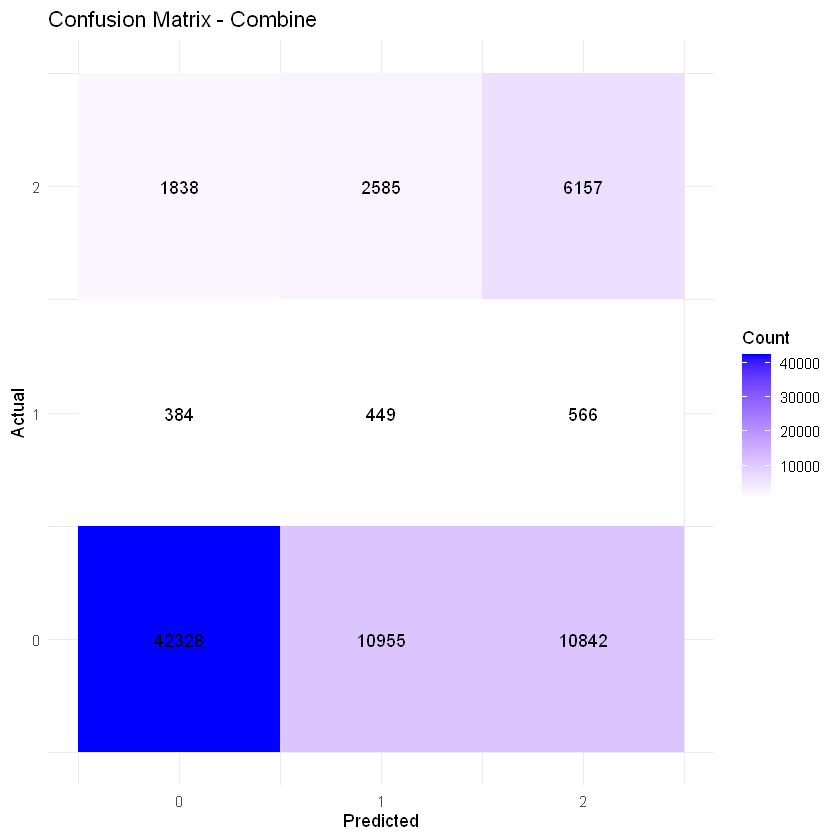

In [93]:
cm_melt <- melt(conf_matrix)
colnames(cm_melt) <- c("Var1", "Var2", "value")
ggplot(data = cm_melt, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    geom_text(aes(label = value), color = "black") +
    scale_fill_gradient(low = "white", high = "blue") +
    labs(x = "Predicted", y = "Actual", fill = "Count") +
    ggtitle("Confusion Matrix - Combine") +
    theme_minimal()

### Regularization

In [104]:
# xài glmnet 
model_lasso <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 1)
model_ridge <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 0)
model_enet <- glmnet(as.matrix(train_combine[, -1]), as.factor(train_combine$Diabetes_012), family = 'multinomial', alpha = 0.5)

In [105]:
# Predict and evaluate for Lasso model
pred_lasso <- predict(model_lasso, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_lasso <- table(test$Diabetes_012, pred_lasso)
cat("Confusion Matrix for Lasso Model:\n")
print(eval_multi_class(cm_lasso))

# Predict and evaluate for Ridge model
pred_ridge <- predict(model_ridge, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_ridge <- table(test$Diabetes_012, pred_ridge)
cat("\nConfusion Matrix for Ridge Model:\n")
print(eval_multi_class(cm_ridge))

# Predict and evaluate for Elastic Net model
pred_enet <- predict(model_enet, newx = as.matrix(test[, -1]), s = 0.01, type = 'class')
cm_enet <- table(test$Diabetes_012, pred_enet)
cat("\nConfusion Matrix for Elastic Net Model:\n")
print(eval_multi_class(cm_enet))

Confusion Matrix for Lasso Model:
$Precision
         0          1          2 
0.94827929 0.03274481 0.34847812 

$Recall
        0         1         2 
0.6690526 0.3009292 0.5930057 

$Accuracy
[1] 0.6517134

$Kappa
[1] 0.2479099

$Macro_F1
[1] 0.4789404


Confusion Matrix for Ridge Model:
$Precision
         0          1          2 
0.94957796 0.03258492 0.34946603 

$Recall
        0         1         2 
0.6631423 0.3195139 0.5814745 

$Accuracy
[1] 0.645472

$Kappa
[1] 0.2436224

$Macro_F1
[1] 0.4795153


Confusion Matrix for Elastic Net Model:
$Precision
         0          1          2 
0.94908518 0.03263245 0.34962638 

$Recall
        0         1         2 
0.6665575 0.3095068 0.5881853 

$Accuracy
[1] 0.6490986

$Kappa
[1] 0.2464402

$Macro_F1
[1] 0.4794767



model với ridge cho kết quả tốt nhất và cũng khá gần với kết quả có được với stepwise_model 

### Naive Bayes

In [116]:
library(e1071)

In [117]:
# xài naivebayes 
model_nb <- naiveBayes(Diabetes_012 ~ ., data = train_combine)
pred_nb <- predict(model_nb, test, type = 'class')
cm_nb <- table(test$Diabetes_012, pred_nb)
print(eval_multi_class(cm_nb))

$Precision
         0          1          2 
0.92917959 0.02557078 0.30789660 

$Recall
        0         1         2 
0.6960624 0.1000715 0.6574669 

$Accuracy
[1] 0.6797409

$Kappa
[1] 0.2474398

$Macro_F1
[1] 0.4504706

